In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
import matplotlib.dates as dates
from ipywidgets import interact, widgets
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import copy
import sympy
%matplotlib inline
import scipy as sp
from scipy.integrate import odeint
import datetime as dt
import timeit
import time
import os
from scipy.interpolate import CubicSpline
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
np.set_printoptions(threshold=np.inf)
from prettytable import PrettyTable  
import matplotlib as mpl
import matplotlib.dates as mdates

TensorFlow 1.x selected.


In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/Davidson.csv",error_bad_lines = False)

In [ ]:
data[34:]

,DATE,COUNTY,TOTAL_CASES,NEW_CASES,NEW_DEATHS,TOTAL_DEATHS,NEW_RECOVERED,TOTAL_RECOVERED
34,4/10/2020,Davidson,1048.0,44.0,0.0,13.0,NaN,204.0
35,4/11/2020,Davidson,1111.0,63.0,0.0,13.0,47.0,251.0
36,4/12/2020,Davidson,1178.0,67.0,0.0,13.0,28.0,279.0
37,4/13/2020,Davidson,1207.0,29.0,3.0,16.0,12.0,291.0
38,4/14/2020,Davidson,1237.0,30.0,2.0,18.0,16.0,307.0
...,...,...,...,...,...,...,...,...
145,7/31/2020,Davidson,18978.0,302.0,3.0,198.0,349.0,14168.0
146,8/1/2020,Davidson,19176.0,198.0,0.0,198.0,255.0,14423.0
147,8/2/2020,Davidson,19320.0,144.0,1.0,199.0,129.0,14552.0
148,8/3/2020,Davidson,19400.0,80.0,3.0,202.0,378.0,14930.0


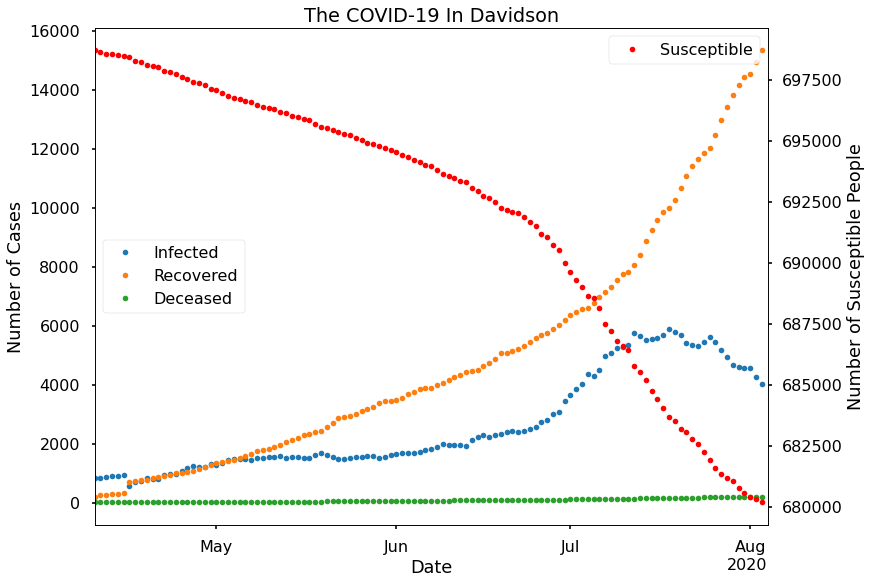

In [ ]:
length = 116#time period
ic = data["TOTAL_CASES"]
IC = ic.iloc[34:].to_numpy().reshape(116,1)
dc = data["TOTAL_DEATHS"]
DC = dc.iloc[34:].to_numpy().reshape(116,1)
re = data["TOTAL_RECOVERED"]
RC = re.iloc[34:].to_numpy().reshape(116,1)
N0 = 	699749#The total population of Davidson
T = np.arange(0,length).reshape(length,1)
II = IC - RC - DC
SS = N0 - II - RC - DC
RR = RC + DC
date_begin = dt.datetime(2020,4,10)
date_end = dt.datetime(2020,8,4)
delta = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delta)
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
lims = (np.datetime64('2020-04-10'), np.datetime64('2020-08-04'))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates, II,'.')
axs.plot(dates, RC,'.')
axs.plot(dates, DC,'.')
axs.set_xlabel("Date")
axs.set_ylabel("Number of Cases")
axs.set_xlim(lims)
axs.legend(("Infected","Recovered","Deceased"),loc = "center left")
ax1 = axs.twinx()
ax1.plot(dates,SS,'.',c = 'red')
ax1.legend(["Susceptible"])
ax1.set_ylabel("Number of Susceptible People")
axs.set_title('The COVID-19 In Davidson')
plt.show()

In [ ]:
np.random.seed(12345)
tf.set_random_seed(12345)
#tf.compat.v1.disable_eager_execution()
class SIR:
    def __init__(self, I, R, S, T,N0, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.layers = layers
        self.N = N0
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.S_pred, self.I_pred, self.R_pred,self.beta_pred,self.gamma_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred = self.physic(
            self.t_tf)
        self.GE_loss = tf.reduce_mean(tf.abs(self.E1_pred)) + tf.reduce_mean(tf.abs(self.E2_pred)) +\
                        tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred))
        self.S_loss = 0
        self.I_loss = 0
        self.R_loss = 0
        iter = 0
        for i in range(len(T)):
            if T[i]%1 == 0:
                self.S_loss += tf.abs(self.S_tf[iter] - self.S_pred[i])
                self.I_loss += tf.abs(self.I_tf[iter] - self.I_pred[i])
                self.R_loss += tf.abs(self.R_tf[iter] - self.R_pred[i])
                iter += 1
        self.OB_loss = (self.I_loss + self.R_loss + self.S_loss)/iter
        self.loss = self.OB_loss + self.GE_loss
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                                                                                       
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]        
            xavier_stddev = np.sqrt(2/(in_dim + out_dim))
            return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)        
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def forward_soft(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def forward_sig(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def physic(self, t):
        beta = self.forward_sig(t,self.weights4,self.biases4)
        gamma = self.forward_sig(t,self.weights5,self.biases5)
        NN=self.N
        S = self.forward_sig(t, self.weights1, self.biases1)
        I = self.forward_sig(t, self.weights2, self.biases2)
        R = self.forward_sig(t, self.weights3, self.biases3)
    
        E1 = tf.gradients(S, t)[0] + beta*S*I
        E2 = tf.gradients(I, t)[0] - beta*S*I + gamma*I
        E3 = tf.gradients(R, t)[0] - gamma*I
        E4 = 1 - (S+I+R)
        return S,I,R,beta,gamma,E1,E2,E3,E4

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S}
                   
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,elapsed))
                start_time = time.time()          
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        beta = self.sess.run(self.beta_pred,tf_dict)
        gamma = self.sess.run(self.gamma_pred,tf_dict)
        #gamma = self.sess.run(self.gamma_pred,tf_dict)
        return S,I,R,beta,gamma

In [ ]:
T = np.arange(0,length - 0.05,0.05)#here I used Nt with 0.1 stepsize
T = T.reshape(len(T),1)
layers = [1,64,64,64,1]
model = SIR(II/N0,RR/N0,SS/N0,T,1,layers)
model.train(120000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

It: 0, Loss: 2.435e+00, Time: 4.61
It: 500, Loss: 2.450e-03, Time: 12.13
It: 1000, Loss: 2.554e-03, Time: 12.06
It: 1500, Loss: 1.916e-03, Time: 12.08
It: 2000, Loss: 2.614e-03, Time: 12.10
It: 2500, Loss: 2.539e-03, Time: 12.08
It: 3000, Loss: 2.044e-03, Time: 12.06
It: 3500, Loss: 2.171e-03, Time: 12.04
It: 4000, Loss: 2.280e-03, Time: 12.03
It: 4500, Loss: 1.920e-03, Time: 11.98
It: 5000, Loss: 2.629e-03, Time: 11.97
It: 5500, Loss: 2.131e-03, Time: 12.07
It: 6000, Loss: 1.654e-03, Time: 11.92
It: 6500, Loss: 1.868e-03, Time: 11.90
It: 7000, Loss: 1.765e-03, Time: 11.95
It: 7500, Loss: 1.595e-03, Time: 12.25
It: 8000, Loss: 1.547e-03, Time: 12.16
It: 8500, Loss: 1.379e-03, Time: 12.00

In [ ]:
T = np.arange(0,116).reshape(116,1)
s,i,r,beta,gamma= model.predict(T)
from scipy.integrate import odeint
# function that returns dz/dt
def sir_model(z,t,beta_value,gamma):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - gamma*i
    drdt = gamma*i
    dzdt = [dsdt,didt,drdt]
    dzdt = np.array(dzdt)
    return dzdt
t = np.arange(0,T.shape[0])
# initial condition
z0 = np.array([SS[0,0]/N0,II[0,0]/N0,RR[0,0]/N0])
print(z0)
rk_s = [0.0]*T.shape[0]
rk_i = [0.0]*T.shape[0]
rk_r = [0.0]*T.shape[0]
rk_s[0] = z0[0]
rk_i[0] = z0[1]
rk_r[0] = z0[2]
# solve ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z = odeint(sir_model,z0,tspan,args=(beta[l-1,0],gamma[l-1,0]))
    # store solution for plotting
    rk_s[l] = z[1][0]
    rk_i[l] = z[1][1]
    rk_r[l] = z[1][2]
    # next initial condition
    z0 = z[1]

[9.98502320e-01 1.18756869e-03 3.10111197e-04]


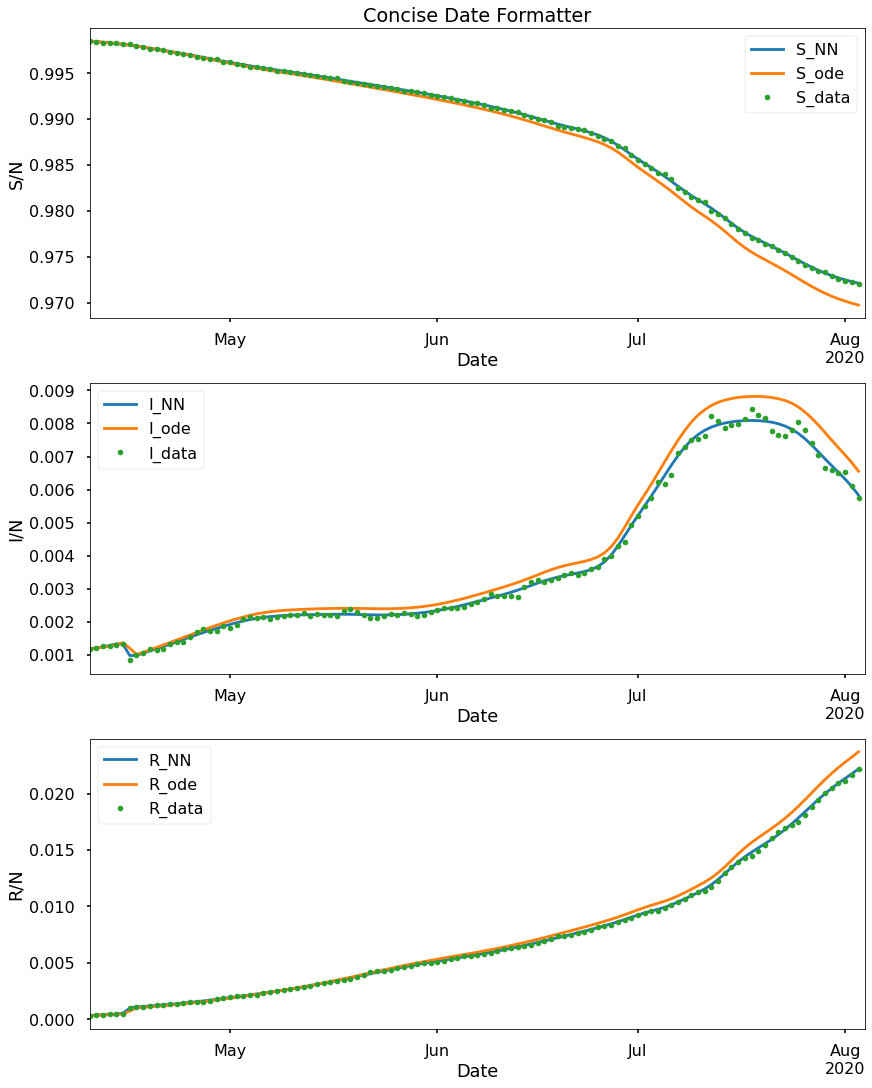

In [ ]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(12, 15))
lims = (np.datetime64('2020-04-10'), np.datetime64('2020-08-04'))
y = np.array([s,i,r])
y1 = np.array([SS/N0,II/N0,RR/N0])
y2 = np.array([rk_s,rk_i,rk_r])
y_label = ["S/N","I/N","R/N"]
legend = [("S_NN","S_ode","S_data"),("I_NN","I_ode","I_data"),("R_NN","R_ode","R_data")]
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, y[nn])
    ax.plot(dates, y2[nn])
    ax.plot(dates, y1[nn],'.')
    ax.set_xlabel("Date")
    ax.set_ylabel(y_label[nn])
    ax.set_xlim(lims)
    ax.legend(legend[nn])
axs[0].set_title('Concise Date Formatter')
plt.show()

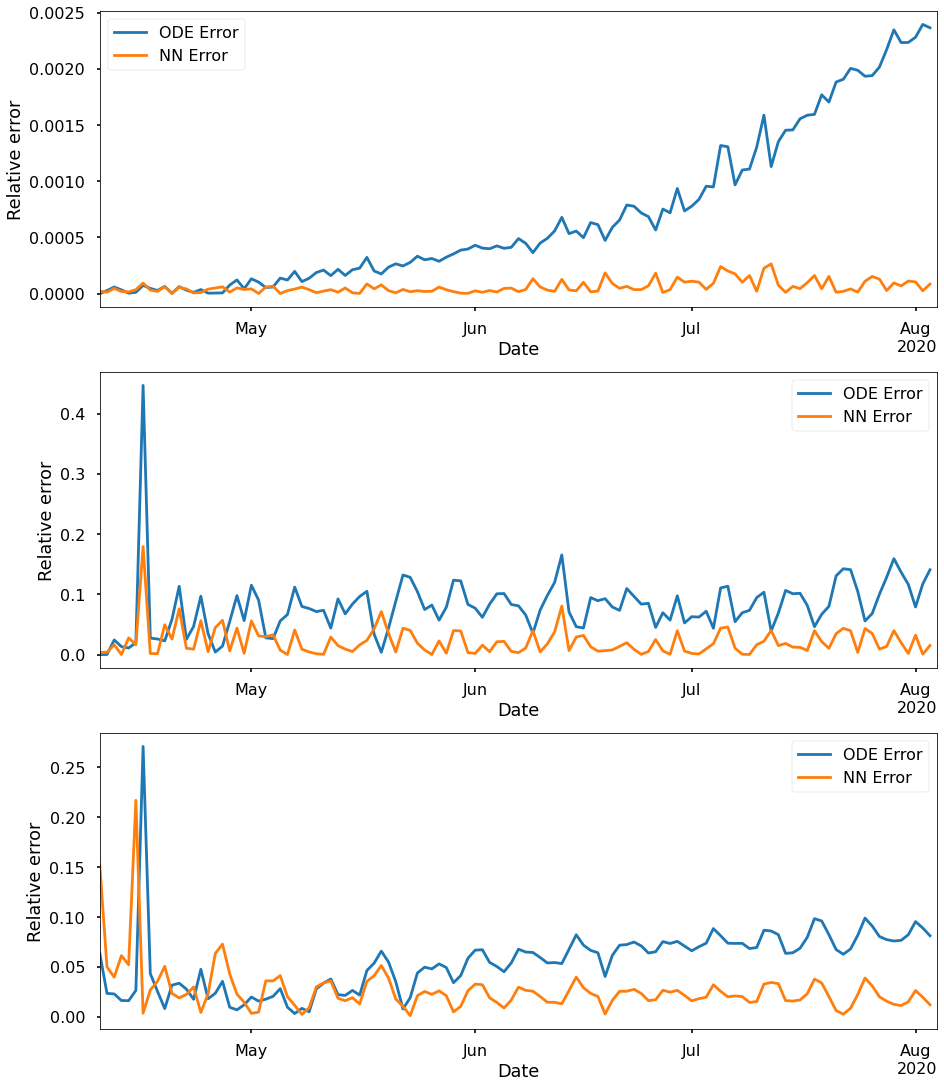

In [ ]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(13, 15))
ode_err = np.array([np.abs(np.array(rk_s).reshape(length,1) - SS/N0)/(SS/N0),np.abs(np.array(rk_i).reshape(length,1) - II/N0)/(II/N0),np.abs(np.array(rk_r).reshape(length,1) - RC/N0)/(RC/N0)])
nn_err = np.array([np.abs(s - SS/N0)/(SS/N0),np.abs(i - II/N0)/(II/N0),np.abs(r - RC/N0)/(RC/N0)])
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, ode_err[nn])
    ax.plot(dates, nn_err[nn])
    ax.set_xlabel("Date")
    ax.set_ylabel('Relative error')
    ax.set_xlim(lims)
    ax.legend(("ODE Error","NN Error"))
plt.show()

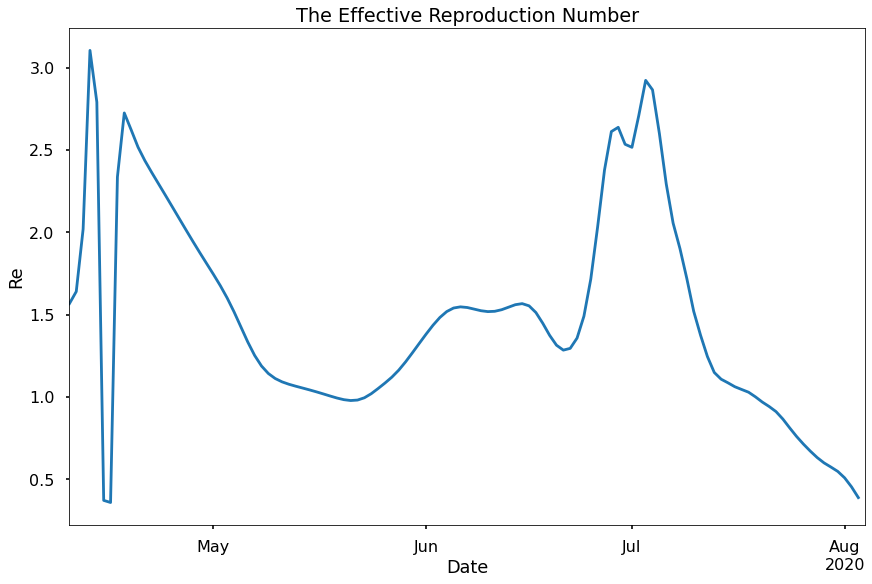

In [ ]:
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates, beta/gamma)
axs.set_xlabel("Date")
axs.set_ylabel("Re")
axs.set_xlim(lims)
axs.set_title("The Effective Reproduction Number")
plt.show()

In [ ]:
#SIRD model
np.random.seed(12345)
tf.set_random_seed(12345)
#tf.compat.v1.disable_eager_execution()
class SIRD:
    def __init__(self, I, R, S,D, T,N0, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.D = D
        self.layers = layers
        self.N = N0
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        self.weights6, self.biases6 = self.initialize_NN(self.layers)
        self.weights7, self.biases7 = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.D_tf = tf.placeholder(tf.float32, shape=[None, self.D.shape[1]])
        self.S_pred, self.I_pred, self.R_pred,self.D_pred,self.beta_pred,self.gamma_pred,self.mu_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred,self.E5_pred = self.physic(
            self.t_tf)
        self.GE_loss = tf.reduce_mean(tf.abs(self.E1_pred)) + tf.reduce_mean(tf.abs(self.E2_pred)) +\
                        tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) + tf.reduce_mean(tf.abs(self.E5_pred))
        self.S_loss = 0
        self.I_loss = 0
        self.R_loss = 0
        self.D_loss = 0
        iter = 0
        for i in range(len(T)):
            if T[i]%1 == 0:
                self.S_loss += tf.abs(self.S_tf[iter] - self.S_pred[i])
                self.I_loss += tf.abs(self.I_tf[iter] - self.I_pred[i])
                self.R_loss += tf.abs(self.R_tf[iter] - self.R_pred[i])
                self.D_loss += tf.abs(self.D_tf[iter] - self.D_pred[i])
                iter += 1
        self.OB_loss = (self.I_loss + self.R_loss + self.S_loss + self.D_loss)/iter
        self.loss = self.OB_loss + self.GE_loss
        '''
        self.loss = tf.reduce_mean(tf.abs(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.abs(self.R_pred - self.R_tf)) +\
                    tf.reduce_mean(tf.abs(self.S_tf - self.S_pred)) +\
                    tf.reduce_mean(tf.abs(self.E1_pred))+ tf.reduce_mean(tf.abs(self.E2_pred)) +\
                    tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) 
        '''
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        # Optimizers
        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})    
        '''                                                                                          
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def forward_soft(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def forward_sig(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def physic(self, t):
        beta = self.forward_sig(t,self.weights4,self.biases4)
        gamma = self.forward_sig(t,self.weights5,self.biases5)
        mu = self.forward_sig(t,self.weights6,self.biases6)
        S = self.forward_sig(t, self.weights1, self.biases1)
        I = self.forward_sig(t, self.weights2, self.biases2)
        R = self.forward_sig(t, self.weights3, self.biases3)
        D = self.forward_sig(t, self.weights7, self.biases7)
        E1 = tf.gradients(S, t)[0] + beta*S*I
        E2 = tf.gradients(I, t)[0] - beta*S*I + (mu+gamma)*I
        E3 = tf.gradients(R, t)[0] - gamma*I
        E4 = tf.gradients(D, t)[0] - mu*I
        E5 = 1 - (S+I+R+D)
        return S,I,R,D,beta,gamma,mu,E1,E2,E3,E4,E5

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S,self.D_tf: self.D}
                   
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                #gamma_value = self.sess.run(self.gamma)
                #beta_value = self.sess.run(self.beta)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,elapsed))
                start_time = time.time()
        '''
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        '''              
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        D = self.sess.run(self.D_pred, tf_dict)
        beta = self.sess.run(self.beta_pred,tf_dict)
        gamma = self.sess.run(self.gamma_pred,tf_dict)
        mu = self.sess.run(self.mu_pred,tf_dict)
        #gamma = self.sess.run(self.gamma_pred,tf_dict)
        return S,I,R,D,beta,gamma,mu

In [ ]:
model1 = SIRD(II/N0,RC/N0,SS/N0,DC/N0,T,1,layers)
model1.train(120000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

It: 0, Loss: 3.918e+00, Time: 4.24
It: 500, Loss: 2.010e-03, Time: 17.58
It: 1000, Loss: 2.038e-03, Time: 17.60
It: 1500, Loss: 2.510e-03, Time: 17.57
It: 2000, Loss: 2.355e-03, Time: 17.57
It: 2500, Loss: 1.905e-03, Time: 17.60
It: 3000, Loss: 1.948e-03, Time: 17.39
It: 3500, Loss: 2.120e-03, Time: 17.58
It: 4000, Loss: 1.853e-03, Time: 17.83
It: 4500, Loss: 1.958e-03, Time: 17.58
It: 5000, Loss: 1.834e-03, Time: 17.31
It: 5500, Loss: 2.642e-03, Time: 17.34
It: 6000, Loss: 2.002e-03, Time: 17.31
It: 6500, Loss: 1.654e-03, Time: 17.29
It: 7000, Loss: 1.827e-03, Time: 17.40
It: 7500, Loss: 1.891e-03, Time: 17.24
It: 8000, Loss: 2.105e-03, Time: 17.26
It: 8500, Loss: 1.489e-03, Time: 17.36

In [ ]:
T = np.arange(0,116).reshape(116,1)
s1,i1,r1,d1,beta1,gamma1,mu1 = model1.predict(T)
def sird_model(z,t,beta_value,gamma,mu):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - (mu+gamma)*i
    drdt = gamma*i
    dddt = mu*i
    dzdt = [dsdt,didt,drdt,dddt]
    dzdt = np.array(dzdt)
    return dzdt
t = np.arange(0,T.shape[0])
# initial condition
z10 = np.array([SS[0,0]/N0,II[0,0]/N0,RC[0,0]/N0,DC[0,0]/N0])
rk1_s = [0.0]*T.shape[0]
rk1_i = [0.0]*T.shape[0]
rk1_r = [0.0]*T.shape[0]
rk1_d = [0.0]*T.shape[0]
rk1_s[0] = z10[0]
rk1_i[0] = z10[1]
rk1_r[0] = z10[2]
rk1_d[0] = z10[3]
# solve ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z1 = odeint(sird_model,z10,tspan,args=(beta1[l-1,0],gamma1[l-1,0],mu1[l-1,0]))
    # store solution for plotting
    rk1_s[l] = z1[1][0]
    rk1_i[l] = z1[1][1]
    rk1_r[l] = z1[1][2]
    rk1_d[l] = z1[1][3]
    # next initial condition
    z10 = z1[1]

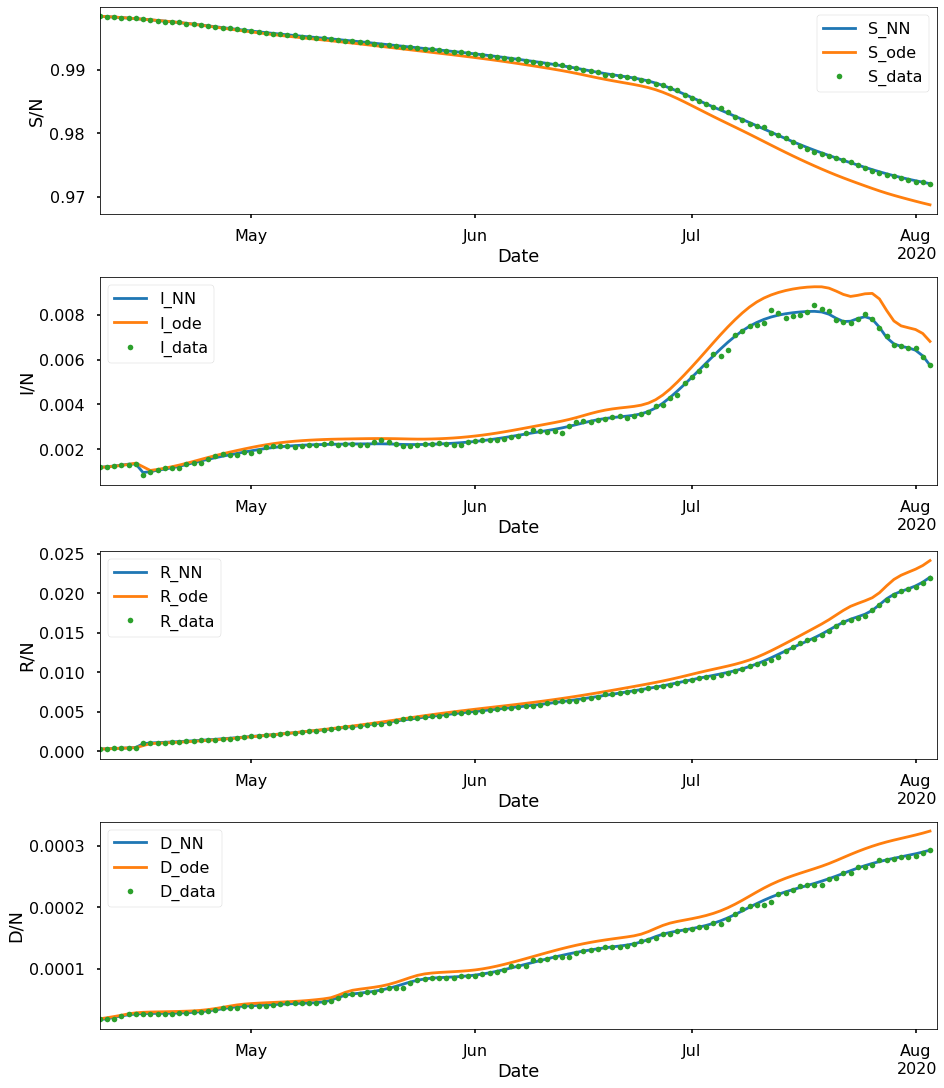

In [ ]:
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
yy = np.array([s1,i1,r1,d1])
yy1 = np.array([SS/N0,II/N0,RC/N0,DC/N0])
yy2 = np.array([rk1_s,rk1_i,rk1_r,rk1_d])
yy_label = ["S/N","I/N","R/N","D/N"]
legend = [("S_NN","S_ode","S_data"),("I_NN","I_ode","I_data"),("R_NN","R_ode","R_data"),("D_NN","D_ode","D_data")]
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, yy[nn])
    ax.plot(dates, yy2[nn])
    ax.plot(dates, yy1[nn],'.')
    ax.set_xlabel("Date")
    ax.set_ylabel(yy_label[nn])
    ax.set_xlim(lims)
    ax.legend(legend[nn])
plt.show()

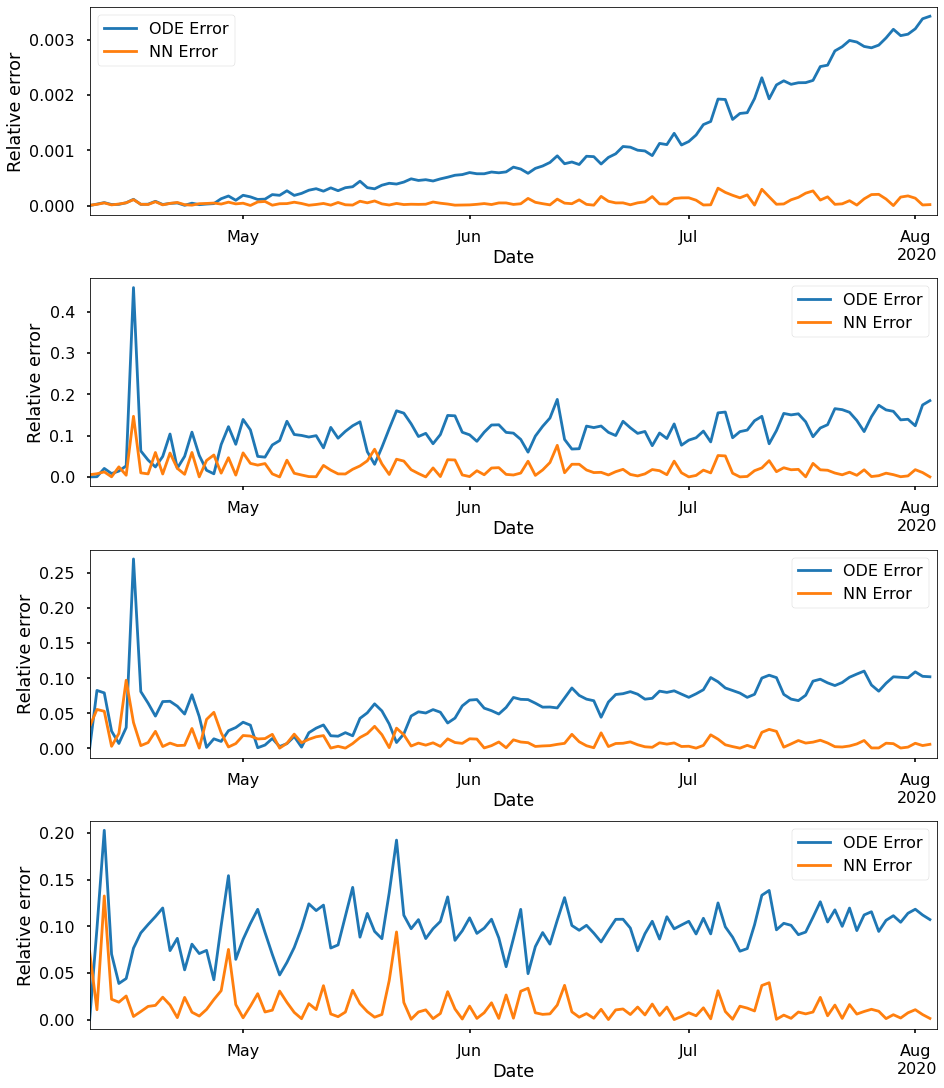

In [ ]:
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
ode1_err = np.array([np.abs(np.array(rk1_s).reshape(length,1) - SS/N0)/(SS/N0),np.abs(np.array(rk1_i).reshape(length,1) - II/N0)/(II/N0),np.abs(np.array(rk1_r).reshape(length,1) - RC/N0)/(RC/N0),np.abs(np.array(rk1_d).reshape(length,1) - DC/N0)/(DC/N0)])
nn1_err = np.array([np.abs(s1 - SS/N0)/(SS/N0),np.abs(i1 - II/N0)/(II/N0),np.abs(r1 - RC/N0)/(RC/N0),np.abs(d1 - DC/N0)/(DC/N0)])
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, ode1_err[nn])
    ax.plot(dates, nn1_err[nn])
    ax.set_xlabel("Date")
    ax.set_ylabel('Relative error')
    ax.set_xlim(lims)
    ax.legend(("ODE Error","NN Error"))
plt.show()

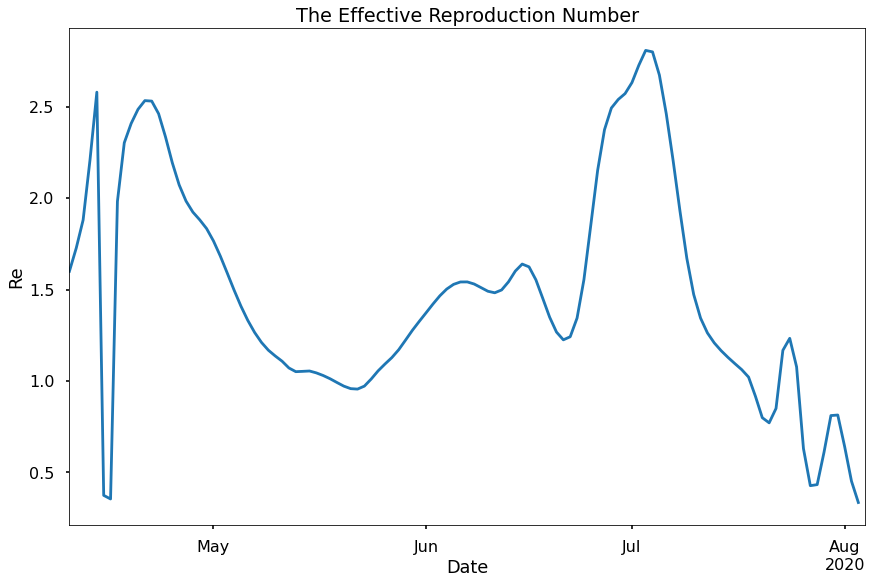

In [ ]:
R01 = beta1/(mu1+gamma1)
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates, R01)
axs.set_xlabel("Date")
axs.set_ylabel("Re")
axs.set_xlim(lims)
axs.set_title("The Effective Reproduction Number")
plt.show()